# Capstone 2: Modeling

### 1. Sourcing and Loading

#### 1a. Import Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#from library.sb_utils import save_file

#### 1b. Load the Data

In [2]:
import hickle as hkl

In [3]:
file = 'stroke_traintest_unscaled_data.hkl'
print("Path of the file..", os.path.abspath(file))

Path of the file.. C:\Users\tscofield\Documents\Git\Capstone2-StrokePrediction\Notebooks\stroke_traintest_unscaled_data.hkl


In [4]:
data = hkl.load(r"C:\Users\tscofield\Documents\Git\Capstone2-StrokePrediction\Data\stroke_traintest_unscaled_data.hkl")

In [5]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [6]:
# make sure the X data looks correct
X_train.head()

,gender,ever_married,Residence_type,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,id,hypertension,heart_disease,avg_glucose_level,bmi
2331,1,1,0,0,0,1,0,0,0,1,0,0,15351,0,0,91.68,32.4
3901,1,1,1,0,0,1,0,0,0,0,1,0,37479,0,0,93.96,33.3
1436,1,1,0,1,0,0,0,0,0,1,0,0,71318,0,0,244.28,29.4
1018,0,1,0,0,0,0,1,0,1,0,0,0,17437,0,0,85.60,25.9
3567,0,1,0,0,0,0,1,0,0,0,1,0,62475,1,0,88.18,33.5


In [7]:
# remove ID columns for modeling
X_train_id = X_train['id']
X_train = X_train.drop(['id'], axis=1)

X_test_id = X_test['id']
X_test = X_test.drop(['id'], axis=1)

X_train.columns

Index(['gender', 'ever_married', 'Residence_type', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'hypertension',
       'heart_disease', 'avg_glucose_level', 'bmi'],
      dtype='object')

In [26]:
# make sure the y data is there
y_train.head()

2331    0
3901    0
1436    0
1018    0
3567    0
Name: stroke, dtype: int64

In [8]:
# verify data set shapes
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (4086, 16)
X_test shape: (1022, 16)
y_train shape: (4086,)
y_test shape: (1022,)


### 2. Create Baseline Models

Now, we can select a few algorithms and create baseline models. In these models, we want to keep things fairly simple and strive to select one or two algorithms to move forward with. Once we select the best models, we can do further parameter testing and try to optimize the performance. Speaking of performance, we will look at the ROC curves for the baseline models to determine their performace. Furthermore, reducing false-negative predictions (predicting non-stroke when actually stroke) is very important in healthcare datasets such as these where the predictions could lead to missing a diagnosis. 

The models that will be tested here are a random forest classifier, support vector machine, logistic regression, XGBoost, and CatBoost.

In [41]:
# create arrays to track results
name = []
AUC = []
F1_score = []

#### 2a. Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, recall_score, fbeta_score

In [10]:
# create grid search and fit model
params = {'n_estimators':[50, 100, 200, 300], 'max_depth':[3,7,20], 'min_samples_split':[2,4,10]}
rfc = RandomForestClassifier()
#rfc_cv = GridSearchCV(rfc, params, scoring='recall', cv=5)
rfc_cv = GridSearchCV(rfc, params, scoring='f1', cv=10)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 7, 20],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1')

In [11]:
# print best parameters
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [29]:
# create model with best parameters
rfc = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=200)
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_proba = rfc.predict_proba(X_test)

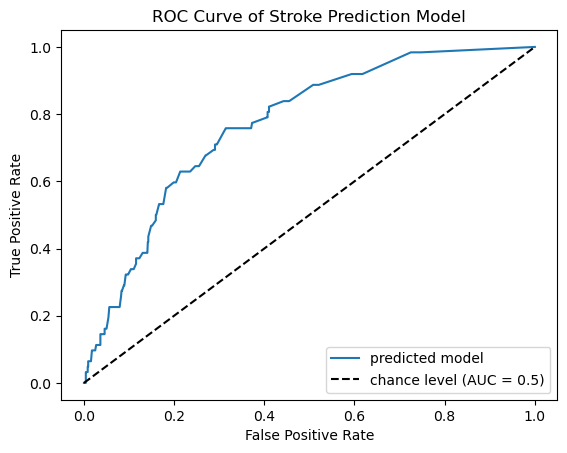

AUC score: 0.7698504704301077


In [30]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [31]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[958,   2],
       [ 62,   0]], dtype=int64)

In [42]:
# populate result arrays
name.append('RandomForest')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

As we can see from the ROC curve and the confusion matrix, this classifier did a bad job at distinguishing the classes. This model has zero recall, meaning it predicted all observations to be '0'.

#### 2b. Support Vector Machine

In [46]:
from sklearn.svm import SVC

In [16]:
# create grid search and fit model
params = {'C':[0.1, 1, 10, 100, 1000], 'gamma':['auto'], 'kernel':['rbf']}
svc = SVC()
svc_cv = GridSearchCV(svc, params, scoring='recall', cv=5)
svc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto'],
                         'kernel': ['rbf']},
             scoring='recall')

In [17]:
# print best parameters
print("Best Parameters: " + str(svc_cv.best_params_))

Best Parameters: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}


In [47]:
# create model with best parameters
svc = SVC(C=1000, gamma='auto', kernel='rbf', probability=True)
svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_test_proba = svc.predict_proba(X_test)

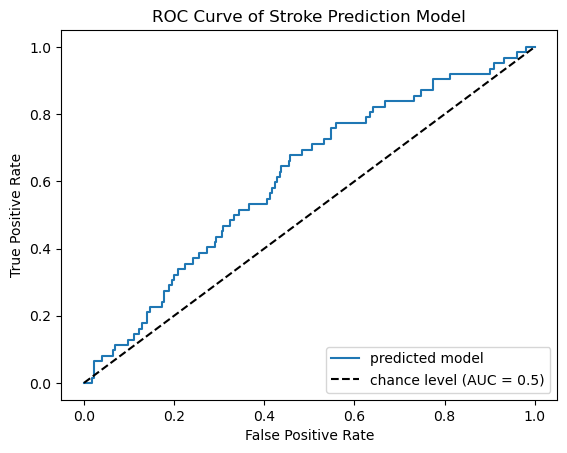

AUC score: 0.6101646505376344


In [48]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [49]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

In [50]:
# populate result arrays
name.append('SVM')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

The same thing happened again: all 62 stroke events were predicted to be non-strokes. This is a problem and a useless model for our goal. We will keep trying to find another model that can distinguish the two classes.

#### 2c. Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

In [22]:
# create grid search and fit model
params = {'penalty':['none', 'l1', 'l2'], 'C':[0.1, 1, 10, 100, 1000]}
logr = LogisticRegression()
logr_cv = GridSearchCV(logr, params, scoring='recall', cv=5)
logr_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='recall')

In [23]:
# print best parameters
print("Best Parameters: " + str(logr_cv.best_params_))

Best Parameters: {'C': 0.1, 'penalty': 'none'}


In [53]:
# create model with best parameters
logr = LogisticRegression(C=0.1, penalty='none')
logr.fit(X_train, y_train)
y_train_pred = logr.predict(X_train)
y_test_proba = logr.predict_proba(X_test)

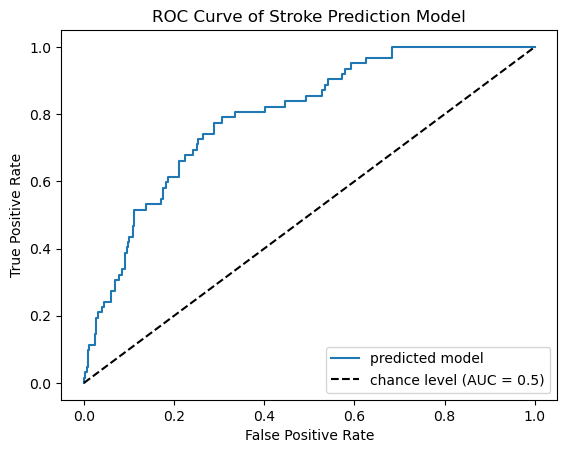

AUC score: 0.7964213709677419


In [54]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [55]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

In [56]:
# populate result arrays
name.append('LogisticRegression')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

Same results...

#### 2d. XGBoost

In [65]:
#! pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 1.7 MB/s eta 0:00:00


In [57]:
from xgboost import XGBClassifier

In [58]:
# train general XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [59]:
# predict on training and testing sets
y_train_pred = xgb_model.predict(X_train)
y_test_proba = xgb_model.predict_proba(X_test)

#y_train_pred = [round(value) for value in y_train_pred]
#y_test_proba = [round(value) for value in y_test_pred]

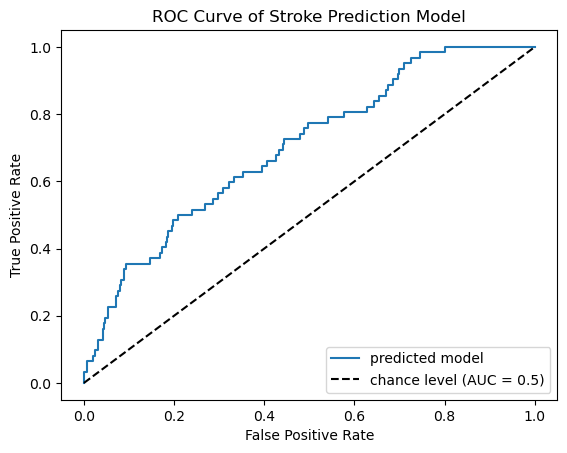

AUC score: 0.7007056451612903


In [60]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [61]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 60,   2]], dtype=int64)

In [62]:
# populate result arrays
name.append('XGBoost')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

This model predicted 2 stroke victims correctly, and predicted 4 incorrectly. This is better than a recall of zero but needs much improvement to be a sensible model.

#### 2e. CatBoost

In [71]:
#! pip install catboost

In [9]:
from catboost import CatBoostClassifier

In [38]:
# create grid search and fit model
params = {'depth':[4,6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[10, 50, 100]}
cbc = CatBoostClassifier()
cbc_cv = GridSearchCV(cbc, params, scoring='recall', cv=5)
cbc_cv.fit(X_train,y_train, silent=True)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001F2004CDEB0>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [10, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='recall')

In [39]:
# print best parameters
print("Best Parameters: " + str(cbc_cv.best_params_))

Best Parameters: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}


In [64]:
# create model with best parameters
cbc = CatBoostClassifier(depth=8, iterations=100, learning_rate=0.1)
cbc.fit(X_train, y_train, silent=True)
y_train_pred = cbc.predict(X_train)
y_test_proba = cbc.predict_proba(X_test)

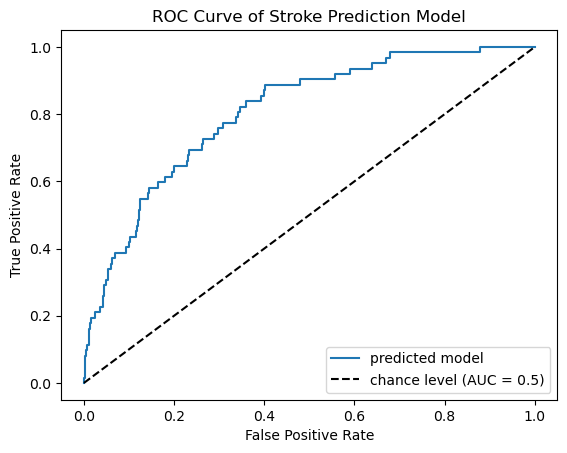

AUC score: 0.806065188172043


In [65]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [66]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

In [67]:
# populate result arrays
name.append('CatBoost')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

### 3. Refine Models with Balanced Data

Given the poor recall and accuracy results of the models above, we will resample the data to remove the class imbalance from the stroke data. We will use SMOTE to resample the data.

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
# Upsample to reduce class imbalance
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [12]:
# Check class imbalance and data size
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 187
Before OverSampling, counts of label '0': 3899 

After OverSampling, the shape of X_train: (7798, 16)
After OverSampling, the shape of y_train: (7798,) 

After OverSampling, counts of label '1': 3899
After OverSampling, counts of label '0': 3899


#### 3a. Random Forest Classifier

In [50]:
# create grid search and fit model
params = {'n_estimators':[50, 100, 200, 300,1000], 'max_depth':[3,7,20], 'min_samples_split':[2,4,10]}
rfc = RandomForestClassifier()
#rfc_cv = GridSearchCV(rfc, params, scoring='recall', cv=5)
rfc_cv = GridSearchCV(rfc, params, scoring='f1', cv=5)
rfc_cv.fit(X_train_res,y_train_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 7, 20],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [50, 100, 200, 300, 1000]},
             scoring='f1')

In [51]:
# print best parameters
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Parameters: {'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 100}


In [71]:
# create model with best parameters
rfc = RandomForestClassifier(max_depth=20, min_samples_split=4, n_estimators=100)
rfc.fit(X_train_res, y_train_res)
y_train_pred = rfc.predict(X_train_res)
y_test_proba = rfc.predict_proba(X_test)

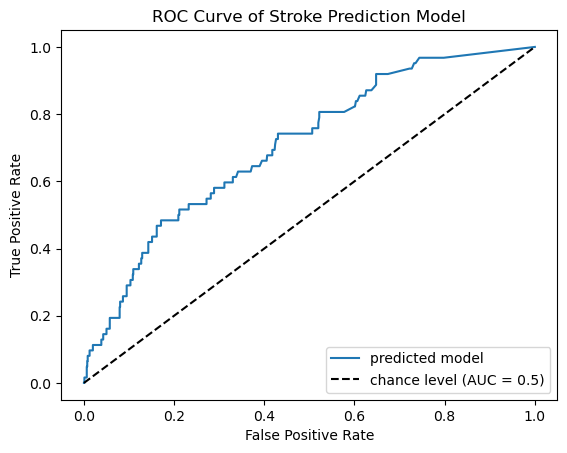

AUC score: 0.7066196236559139


In [72]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [73]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[949,  11],
       [ 57,   5]], dtype=int64)

In [74]:
# populate result arrays
name.append('RandomForest_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

#### 3b. Support Vector Machine

In [57]:
# create grid search and fit model
params = {'C':[0.1, 1, 10, 100, 1000], 'gamma':['auto'], 'kernel':['rbf']}
svc = SVC()
svc_cv = GridSearchCV(svc, params, scoring='f1', cv=5)
svc_cv.fit(X_train_res,y_train_res)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto'],
                         'kernel': ['rbf']},
             scoring='f1')

In [58]:
# print best parameters
print("Best Parameters: " + str(svc_cv.best_params_))

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [75]:
# create model with best parameters
svc = SVC(C=10, gamma='auto', kernel='rbf', probability=True, random_state=42)
svc.fit(X_train_res, y_train_res)
y_train_pred = svc.predict(X_train_res)
y_test_proba = svc.predict_proba(X_test)

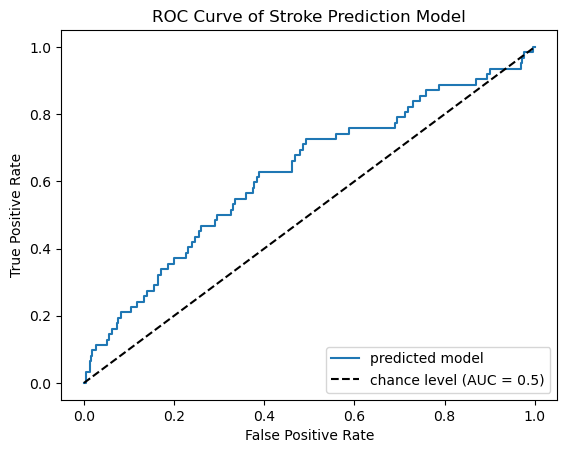

AUC score: 0.6233702956989248


In [76]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [77]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[931,  29],
       [ 55,   7]], dtype=int64)

In [78]:
# populate result arrays
name.append('SVM_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

#### 3c. Logistic Regression

In [62]:
# create grid search and fit model
params = {'penalty':['none', 'l1', 'l2'], 'C':[0.1, 1, 10, 100, 1000]}
logr = LogisticRegression(random_state=42)
logr_cv = GridSearchCV(logr, params, scoring='f1', cv=5)
logr_cv.fit(X_train_res,y_train_res)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='f1')

In [63]:
# print best parameters
print("Best Parameters: " + str(logr_cv.best_params_))

Best Parameters: {'C': 10, 'penalty': 'l2'}


In [79]:
# create model with best parameters
logr = LogisticRegression(C=10, penalty='l2', random_state=42)
logr.fit(X_train_res, y_train_res)
y_train_pred = logr.predict(X_train_res)
y_test_proba = logr.predict_proba(X_test)

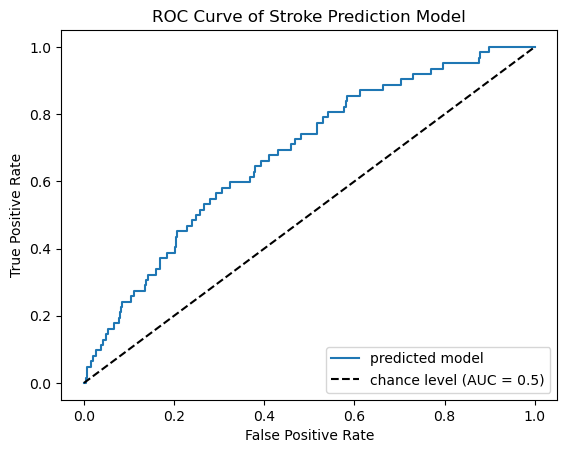

AUC score: 0.6810987903225807


In [80]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [81]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[940,  20],
       [ 57,   5]], dtype=int64)

In [82]:
# populate result arrays
name.append('LogisticRegression_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

#### 3d. XGBoost Classifier

In [74]:
# train general XGBoost classifier
params = {'n_estimators': [1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 5, 10, 15, 20],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 1],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 1],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 1],
    'objective': ["reg:squarederror"],
    'eval_metric': ['mae']}
xgb_model = XGBClassifier(random_state=42)
logr_cv = RandomizedSearchCV(xgb_model, params, scoring='f1', cv=5)
logr_cv.fit(X_train_res,y_train_res)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=42, ...),
             

In [75]:
# print best parameters
print("Best Parameters: " + str(logr_cv.best_params_))

Best Parameters: {'subsample': 0.7, 'reg_lambda': 0.2, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'eval_metric': 'mae', 'colsample_bytree': 0.7}


In [83]:
xgb_model = XGBClassifier(subsample= 0.7, reg_lambda= 0.2, reg_alpha= 1, objective= 'reg:squarederror', 
                          n_estimators= 1000, min_child_weight= 10, max_depth= 7, learning_rate= 0.1, gamma= 0.1, 
                          eval_metric= 'mae', colsample_bytree= 0.7, random_state=42)
xgb_model.fit(X_train_res, y_train_res)
y_train_pred = xgb_model.predict(X_train_res)
y_test_proba = xgb_model.predict_proba(X_test)

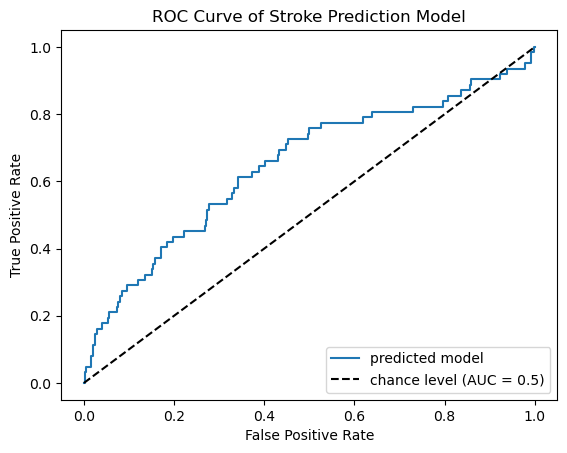

AUC score: 0.6480174731182795


In [84]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [85]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[944,  16],
       [ 59,   3]], dtype=int64)

In [86]:
# populate result arrays
name.append('XGBoost_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

#### 3e. CatBoost Classifier

In [80]:
# create grid search and fit model
params = {'depth':[4,6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[10, 50, 100]}
cbc = CatBoostClassifier(random_state=42)
cbc_cv = GridSearchCV(cbc, params, scoring='f1', cv=5)
cbc_cv.fit(X_train_res,y_train_res, silent=True)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001F2004E6D90>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [10, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1')

In [81]:
# print best parameters
print("Best Parameters: " + str(cbc_cv.best_params_))

Best Parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}


In [35]:
cbc_model = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.1, random_state=42)
cbc_model.fit(X_train_res, y_train_res, silent=True)
y_train_pred = cbc_model.predict(X_train_res)
y_test_proba = cbc_model.predict_proba(X_test)

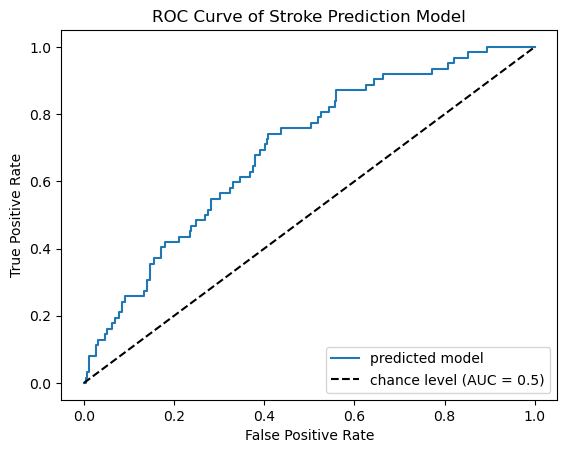

AUC score: 0.694304435483871


In [36]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [37]:
# print confusion matrix
y_test_pred = np.argmax(y_test_proba, axis=1)
confusion_matrix(y_test, y_test_pred)

array([[950,  10],
       [ 60,   2]], dtype=int64)

In [38]:
# threshold tuning for classification

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int');

# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
#scores = [f1_score(y_test, to_labels(y_test_proba[:,1], t)) for t in thresholds]
scores = [fbeta_score(y_test, to_labels(y_test_proba[:,1], t), beta=1.5) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.089, F-Score=0.25754


In [39]:
# print confusion matrix for optimal threshold
labels = to_labels(y_test_proba[:,1], 0.089)
confusion_matrix(y_test, labels)

array([[565, 395],
       [ 16,  46]], dtype=int64)

In [90]:
# populate result arrays
name.append('CatBoost_scaled')
AUC.append(roc_auc_score(y_test, y_test_proba[:,1]))
F1_score.append(f1_score(y_test, np.round(y_test_proba[:,1])))

In [133]:
# find feature importance of CatBoost model
feature_imp = cbc_model.feature_importances_
feature_names = cbc_model.feature_names_
importances_df = pd.DataFrame({'Feature Name':feature_names, 'Importance':feature_imp})
importances_df = importances_df.sort_values('Importance', ascending=False)
importances_df

,Feature Name,Importance
10,smoking_status_never smoked,16.820915
8,smoking_status_Unknown,15.323470
5,work_type_Private,11.276049
9,smoking_status_formerly smoked,10.260900
11,smoking_status_smokes,9.788235
14,avg_glucose_level,6.995682
3,work_type_Govt_job,6.308333
6,work_type_Self-employed,6.209264
15,bmi,5.670585
7,work_type_children,3.179979


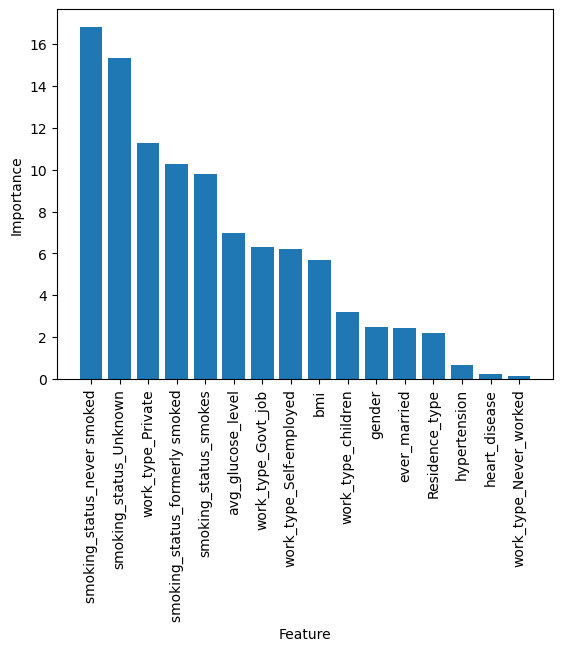

In [135]:
# plot importances
plt.bar(importances_df['Feature Name'], importances_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

In [21]:
# Train again on 5 most important features
imp_features = ['smoking_status_never smoked', 'smoking_status_Unknown', 'work_type_Private', 'smoking_status_formerly smoked', \
                'smoking_status_smokes', 'avg_glucose_level', 'work_type_Govt_job', 'work_type_Self-employed', 'bmi']
X_train_5imp = X_train_res[imp_features]
X_test_5imp = X_test[imp_features]

# create grid search and fit model
params = {'depth':[4,6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[10, 50, 100]}
cbc = CatBoostClassifier(random_state=42)
cbc_cv = GridSearchCV(cbc, params, scoring='f1', cv=5)
cbc_cv.fit(X_train_5imp,y_train_res, silent=True)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001FA356CAEB0>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [10, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1')

In [22]:
# print best parameters
print("Best Parameters: " + str(cbc_cv.best_params_))

Best Parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}


In [23]:
cbc_model = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.1, random_state=42)
cbc_model.fit(X_train_5imp, y_train_res, silent=True)
y_train_pred = cbc_model.predict(X_train_5imp)
y_test_proba = cbc_model.predict_proba(X_test_5imp)

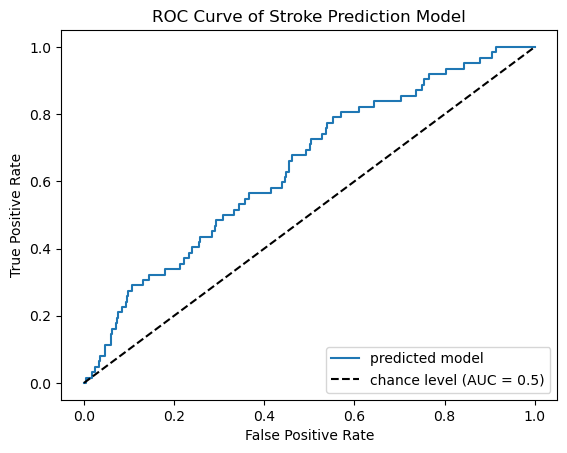

AUC score: 0.6421034946236558


In [24]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])

plt.plot(fpr, tpr, label="predicted model")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Stroke Prediction Model")
plt.legend(loc='lower right')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_proba[:,1])))

In [34]:
# print confusion matrix
#y_test_pred = np.argmax(y_test_proba, axis=1)
#confusion_matrix(y_test, y_test_pred)

labels = to_labels(y_test_proba[:,1], 0.275)
confusion_matrix(y_test, labels)

array([[857, 103],
       [ 44,  18]], dtype=int64)

### Model Selection and Discussion

In [95]:
# results array
results_df = pd.DataFrame({'Model Name':name, 'AUC':AUC, 'F1 Score':F1_score})
results_df

,Model Name,AUC,F1 Score
0,RandomForest,0.769850,0.000000
1,SVM,0.610165,0.000000
2,LogisticRegression,0.796421,0.000000
3,XGBoost,0.700706,0.062500
4,CatBoost,0.806065,0.000000
5,RandomForest_scaled,0.706620,0.128205
6,SVM_scaled,0.623370,0.142857
7,LogisticRegression_scaled,0.681099,0.114943
8,XGBoost_scaled,0.648017,0.074074
9,CatBoost_scaled,0.693683,0.141176
